<a href="https://colab.research.google.com/github/yiihuang/Deep_Learning/blob/master/simple_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main imports**

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import sleep

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
    ])),
shuffle=True, batch_size=64, drop_last=True)

img_width = 28
n_channels = 1
train_iterator = iter(cycle(train_loader))
print(f'> Size of training dataset {len(train_loader.dataset)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.72MB/s]

> Size of training dataset 60000


**View some of the test dataset**

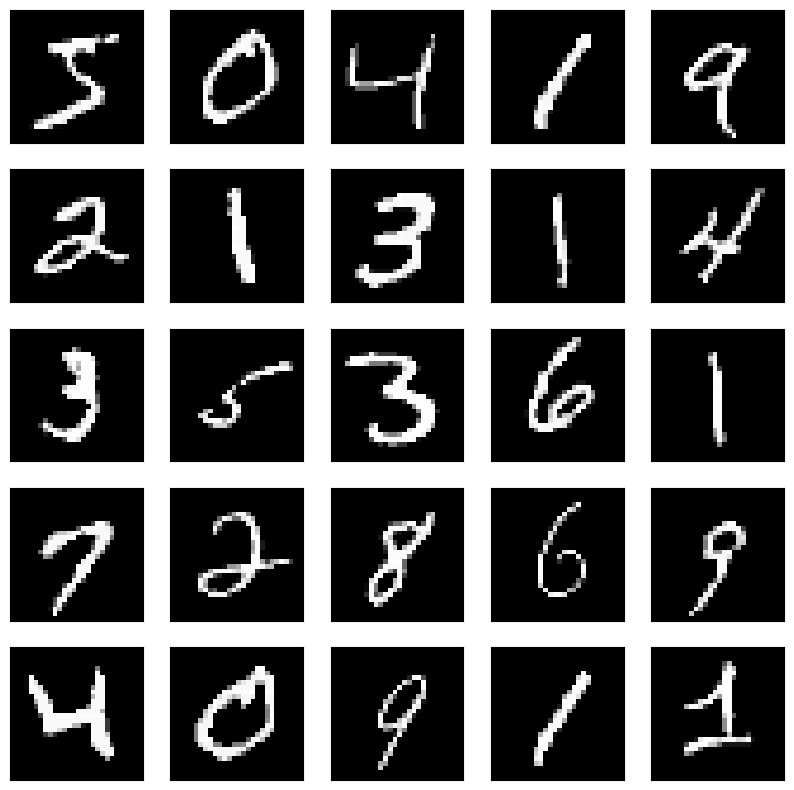

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if n_channels == 1:
        plt.imshow(train_loader.dataset[i][0].clamp(0,1).repeat(3,1,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

**Define two models: (1) Generator, and (2) Discriminator**

In [4]:
# define the model
class Generator(nn.Module):
    def __init__(self, latent_size=100):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, n_channels*img_width*img_width),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), n_channels, img_width, img_width)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(n_channels*img_width*img_width, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1), # 1 output for real/fake
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer(x)
        return x

G = Generator().to(device)
D = Discriminator().to(device)

print(f'> Number of generator parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(D.parameters()))}')

# initialise the optimiser
optimiser_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimiser_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()
epoch = 0

> Number of generator parameters 1510032
> Number of discriminator parameters 533505


**Main training loop**

loss d: 0.817, loss g: 0.644


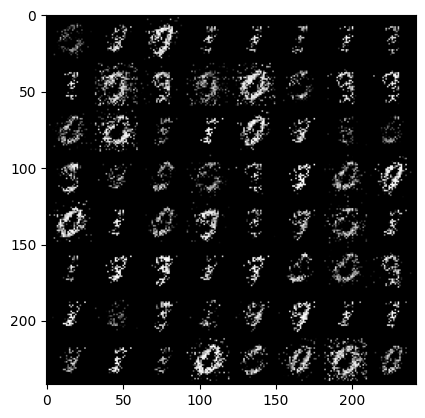

loss d: 0.924, loss g: 0.601


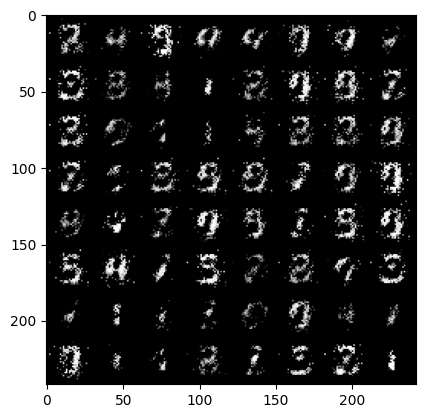

loss d: 0.917, loss g: 0.588


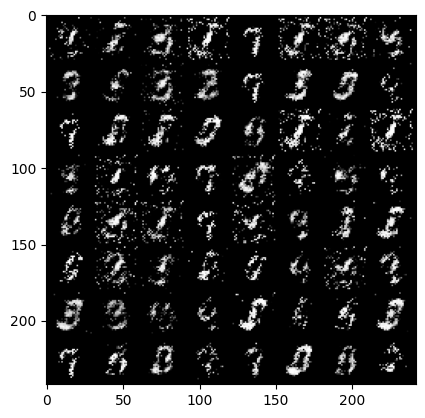

loss d: 1.029, loss g: 0.551


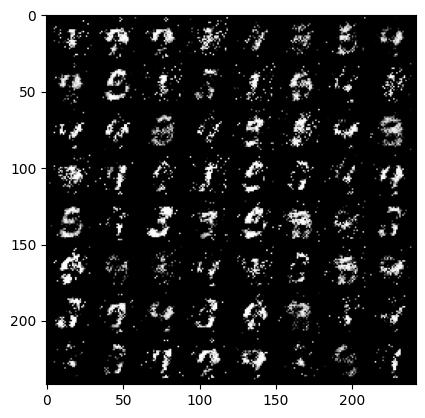

loss d: 1.042, loss g: 0.512


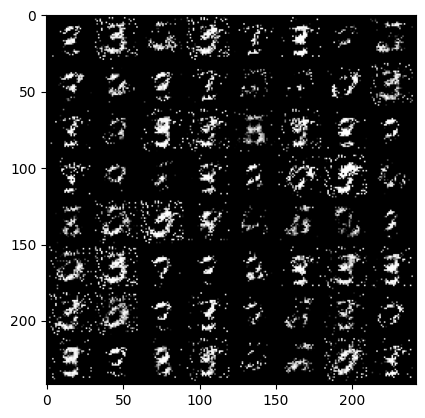

loss d: 1.136, loss g: 0.472


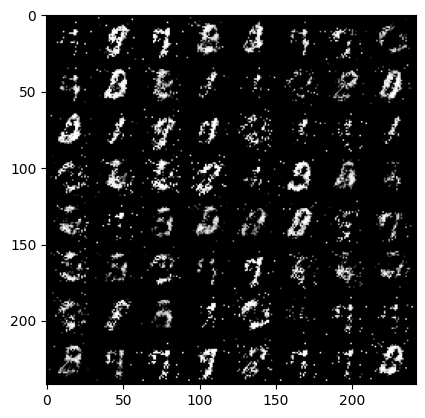

loss d: 1.219, loss g: 0.432


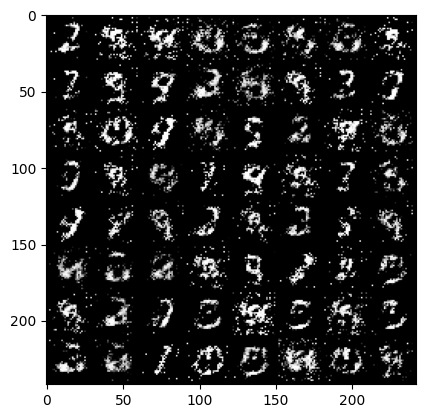

loss d: 1.261, loss g: 0.419


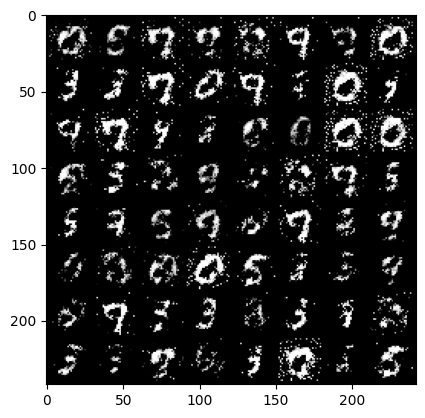

loss d: 1.176, loss g: 0.448


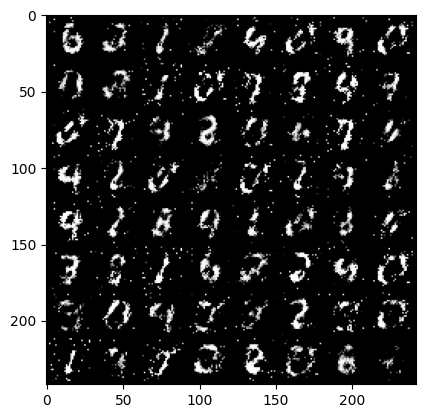

loss d: 1.095, loss g: 0.475


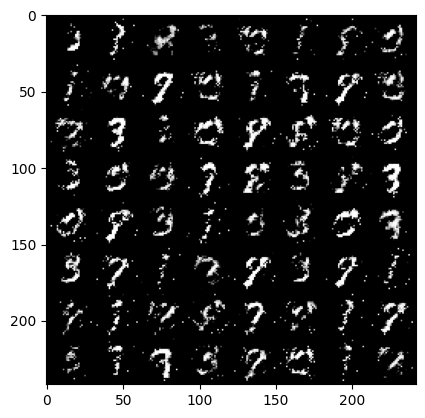

loss d: 1.199, loss g: 0.435


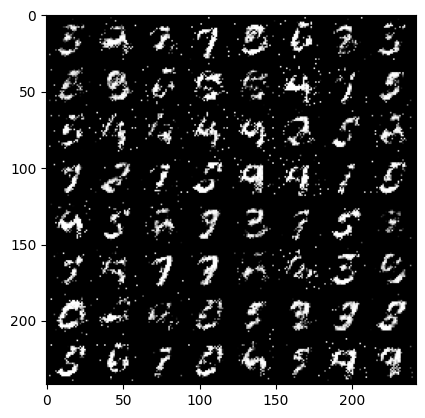

loss d: 1.226, loss g: 0.419


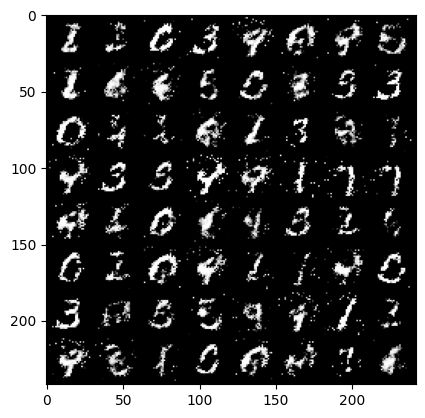

loss d: 1.107, loss g: 0.448


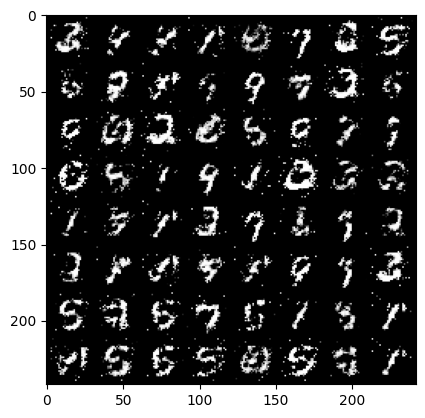

loss d: 1.115, loss g: 0.485


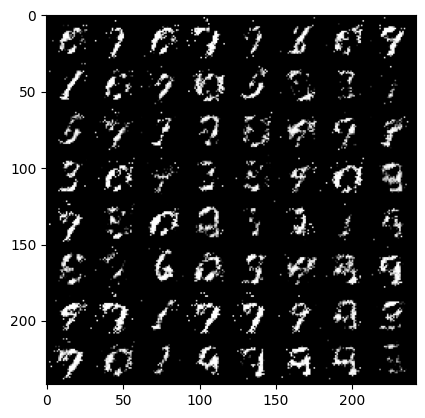

loss d: 1.040, loss g: 0.514


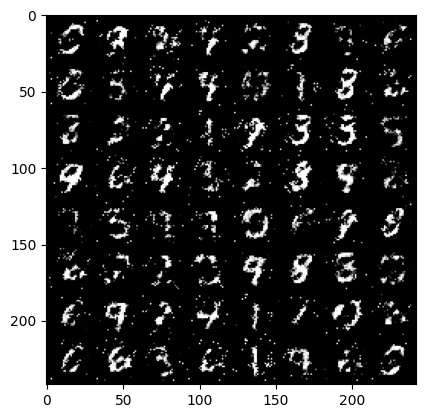

loss d: 0.953, loss g: 0.513


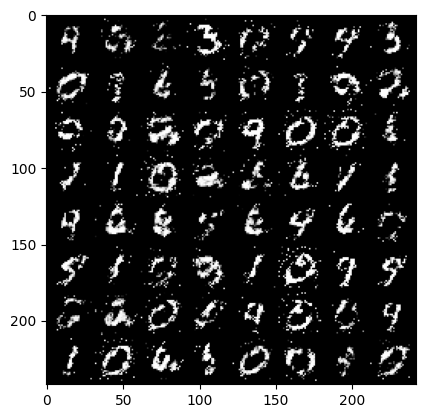

loss d: 1.046, loss g: 0.507


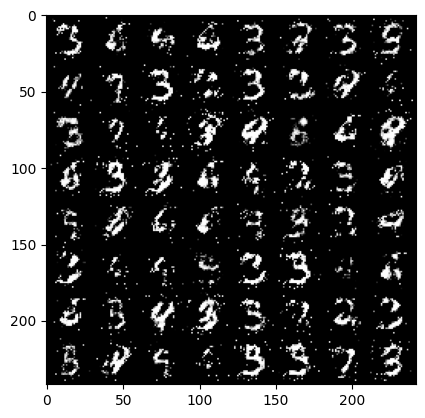

loss d: 1.233, loss g: 0.432


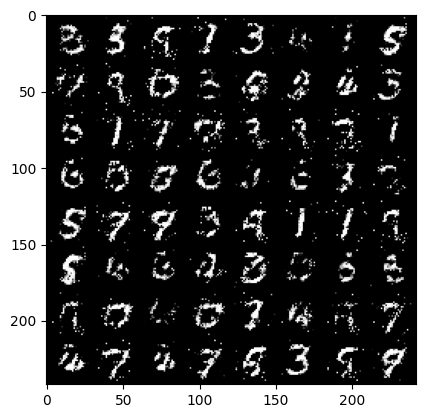

loss d: 1.101, loss g: 0.480


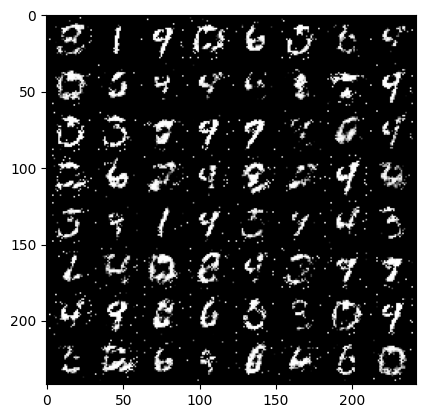

loss d: 1.198, loss g: 0.462


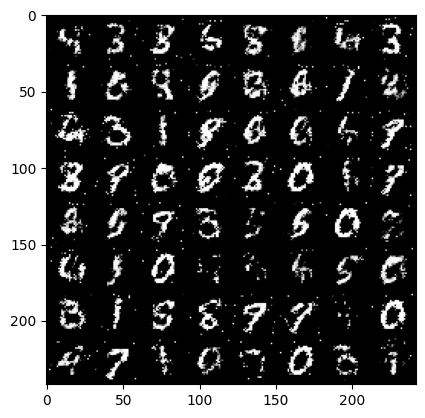

In [5]:
# training loop
while (epoch<20):

    # arrays for metrics
    logs = {}
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(500):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # train discriminator
        g = G(torch.randn(x.size(0), 100).to(device))
        l_r = bce_loss(D(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
        l_f = bce_loss(D(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
        loss_d = (l_r + l_f)/2.0
        optimiser_D.zero_grad()
        loss_d.backward()
        optimiser_D.step()

        # train generator
        g = G(torch.randn(x.size(0), 100).to(device))
        loss_g = bce_loss(D(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
        optimiser_G.zero_grad()
        loss_g.backward()
        optimiser_G.step()

        gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
        dis_loss_arr = np.append(dis_loss_arr, loss_d.item())

    # plot some examples
    G.eval()
    g = G(torch.randn(x.size(0), 100).to(device))
    print('loss d: {:.3f}, loss g: {:.3f}'.format(gen_loss_arr.mean(), dis_loss_arr.mean()))
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.clamp(0,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)
    G.train()

    epoch = epoch+1